# L3 Fields visualization : 
- plot mean KE geo/cyclo
- plot mean vorticity geo/cyclo

- produce animation


In [2]:
import os
import sys
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import numpy as np
import xarray as xr
import pandas as pd

import jax
import jax.numpy as jnp
import jaxparrow as jpw

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *

%matplotlib inline
from matplotlib import pyplot as plt

path_fields = '/home/bouxdecl/Documents/MEOM_internship_2024/save_data/fields_data'

path_save_plot = '../save_plots/save_plots_2024-06-28_L3Fields_comparison'

bbox_drifters = [0, 13.5, 36.5, 44]
bbox_mediterranea = [-5.8, 36.5, 30, 44.5]
bbox_trace = [0, 9, 36.5, 44]

#### func

In [3]:
def plot2d(lon, lat, data, bbox: tuple=bbox_mediterranea, cmap='Oranges', center_bar=False, vmax=None, vmin=None, fraction_cbar=0.033,  title= None, save_name=None):
    # Set up the figure and map projection
    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    _ = ax.gridlines(draw_labels=True,)

    # Add land feature for better visualization
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    # Set the map extent
    ax.set_extent(bbox, crs=crs)

    # Plot the density of points

    # vmin, vmax
    if not vmax:
            vmax = np.nanmax(np.abs(data))
    if not vmin:                
        if center_bar:
            vmin = - vmax
        else:
            vmin = np.nanmin(data)


    mesh = ax.pcolormesh(lon, lat, data, transform=crs, cmap=cmap, vmin=vmin, vmax=vmax)

    # Add a color bar to show the density scale
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=fraction_cbar, pad=0.08)
    #cbar.set_label('Density')

    if title:
        ax.set_title(title)
        
    ### SAVE
    if save_name:
        ax.set_title(save_name)
        save_name = save_name
        plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

In [4]:

# MIOST field data
ds_swot = xr.open_dataset(os.path.join(path_fields, 'field_L3SWOT.nc'))
ds_swot  = add_Tgrid_velocities(ds_swot, replace=False)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


#### SSH


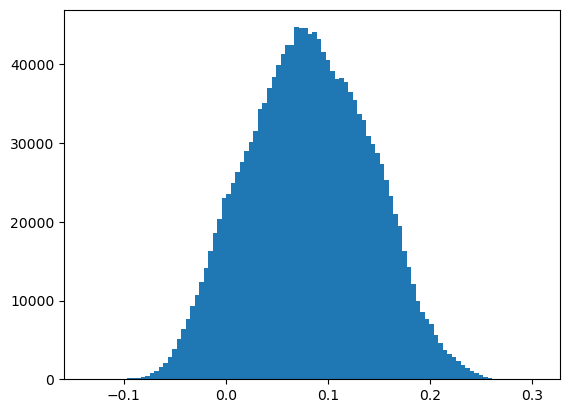

In [5]:
_ = plt.hist(ds_swot.ssh.values.flatten(), bins=100)

#### KE moyen

In [6]:
# dataset span
print(ds_swot.time.min().values)
print(ds_swot.time.max().values)

2023-03-30T00:12:09.000000000
2023-07-09T08:16:31.000000000


In [7]:
# reduce time span

start_time = '2020-05-01'
end_time = '2024-05-31'

#start_time = '2023-05-01'
#end_time = '2023-05-31'

#choose between bbox_mediterranea & bbox_drifters
bbox = bbox_trace

In [8]:

# SWOT
ds = ds_swot 


#select data
ds = restrain_domain(ds, *bbox)
ds = ds.sel(time=slice(start_time, end_time))

#get data
lon, lat = ds.longitude, ds.latitude

KE_var_raw = ( ds.u_var_t**2 + ds.v_var_t**2   ).mean(dim='time').values
KE_geo_raw = ( ds.u_geos_t**2 + ds.v_geos_t**2 ).mean(dim='time').values

KE_var, _ = replace_outliers_with_nan_zscore(KE_var_raw, 2)
KE_geo, _ = replace_outliers_with_nan_zscore(KE_geo_raw, 2)

diff_raw = (KE_var - KE_geo) /KE_geo
diff, _ = replace_outliers_with_nan_zscore(diff_raw, 5)

In [9]:
path_save_plot

'../save_plots/save_plots_2024-06-28_L3Fields_comparison'

"\n#plot data\nplot2d(lon, lat, KE_var, bbox, center_bar=False, title='Mean cyclo KE over may 2023 of L3SWOT')\nplt.savefig(os.path.join(path_save_plot, 'Mean cyclo KE over over may 2023 of L3SWOT'), bbox_inches='tight', dpi = 300)\n\nplot2d(lon, lat, KE_geo, bbox, center_bar=False, title='Mean geo KE over may 2023 of L3SWOT')\nplt.savefig(os.path.join(path_save_plot, 'Mean geo KE over the 1-day period of L3SWOT'), bbox_inches='tight', dpi = 300)\n\nplot2d(lon, lat, diff, bbox, cmap='RdBu_r', center_bar=True, vmax= 1, title='<cyclo KE> - <geo KE> over may 2023 of L3SWOT')\nplt.savefig(os.path.join(path_save_plot, '<cyclo KE> - <geo KE> /<geo KE>  over the 1-day period of L3SWOT'), bbox_inches='tight', dpi = 300)\n"

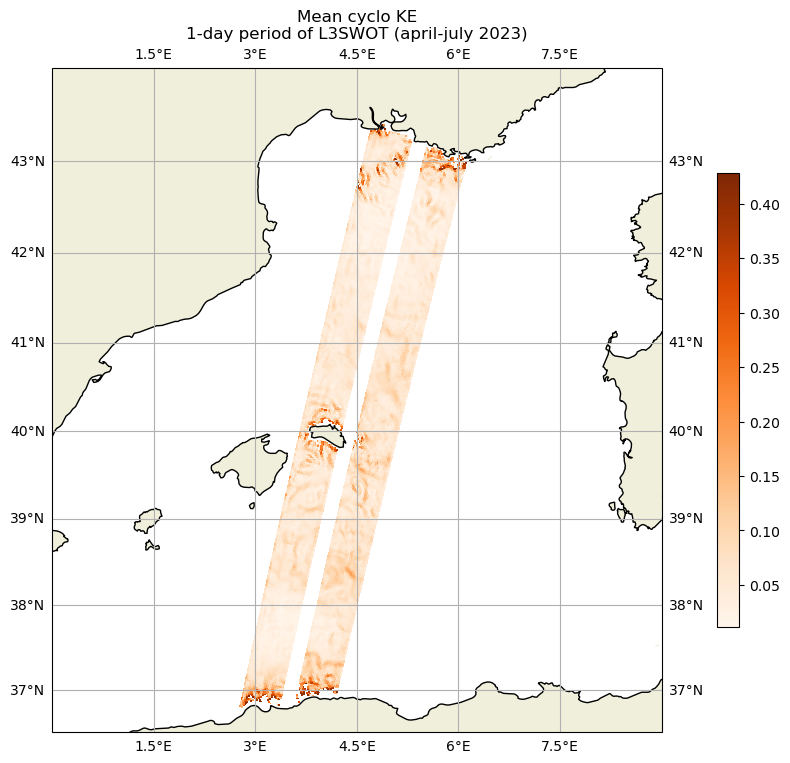

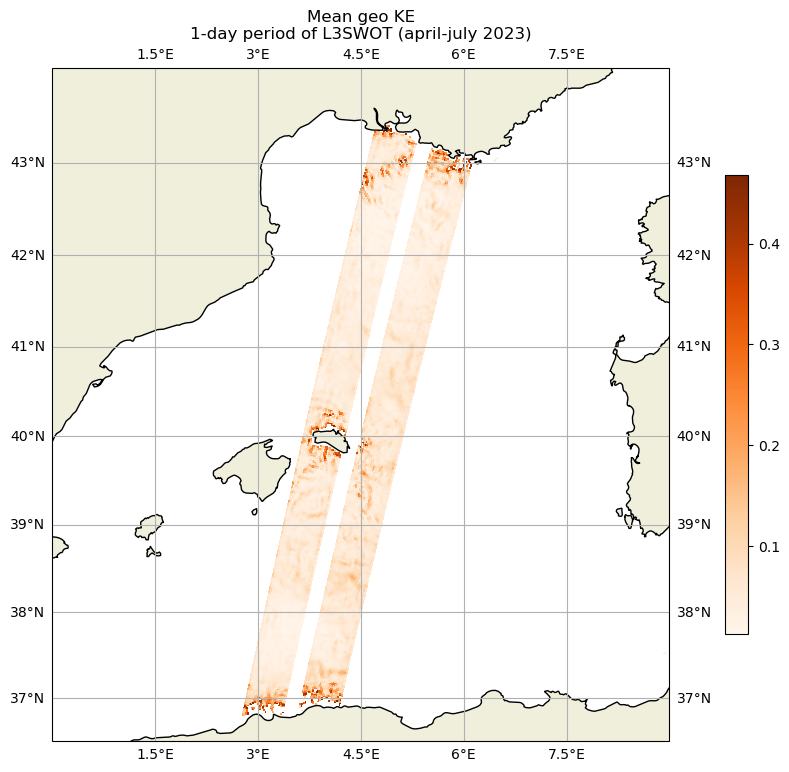

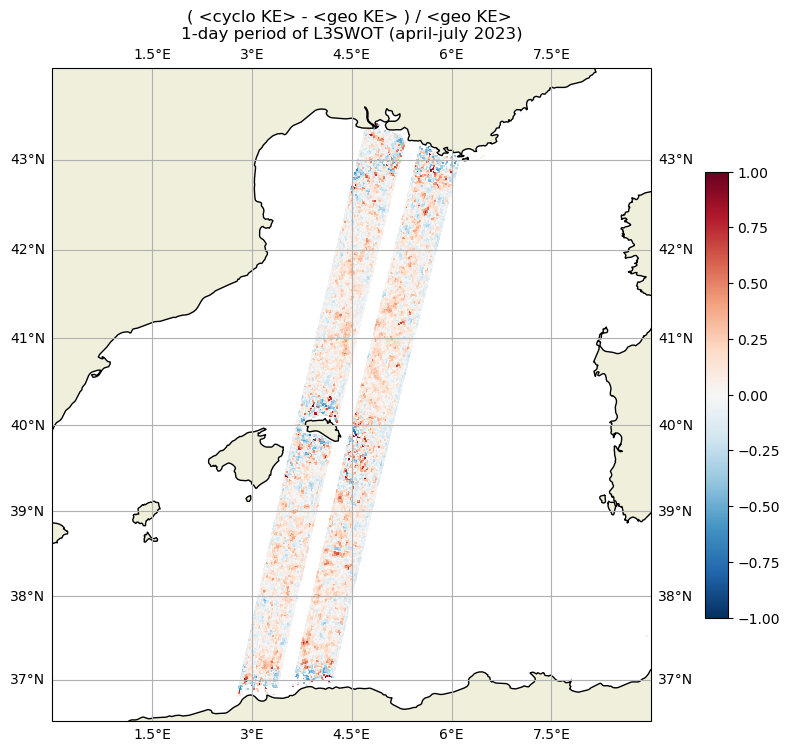

In [10]:
#plot data

plot2d(lon, lat, KE_var, bbox, center_bar=False, title='Mean cyclo KE\n1-day period of L3SWOT (april-july 2023)')
plt.savefig(os.path.join(path_save_plot, 'Mean cyclo KE 1-day period of L3SWOT (april-july 2023)'), bbox_inches='tight', dpi = 300)

plot2d(lon, lat, KE_geo, bbox, center_bar=False, title='Mean geo KE\n1-day period of L3SWOT (april-july 2023)')
plt.savefig(os.path.join(path_save_plot, 'Mean geo KE 1-day period of L3SWOT (april-july 2023)'), bbox_inches='tight', dpi = 300)

plot2d(lon, lat, diff, bbox, cmap='RdBu_r', center_bar=True, vmax= 1, title='( <cyclo KE> - <geo KE> ) / <geo KE> \n1-day period of L3SWOT (april-july 2023)')
plt.savefig(os.path.join(path_save_plot, '<cyclo KE> - <geo KE> 1-day period of L3SWOT (april-july 2023)'), bbox_inches='tight', dpi = 300)


'''
#plot data
plot2d(lon, lat, KE_var, bbox, center_bar=False, title='Mean cyclo KE over may 2023 of L3SWOT')
plt.savefig(os.path.join(path_save_plot, 'Mean cyclo KE over over may 2023 of L3SWOT'), bbox_inches='tight', dpi = 300)

plot2d(lon, lat, KE_geo, bbox, center_bar=False, title='Mean geo KE over may 2023 of L3SWOT')
plt.savefig(os.path.join(path_save_plot, 'Mean geo KE over the 1-day period of L3SWOT'), bbox_inches='tight', dpi = 300)

plot2d(lon, lat, diff, bbox, cmap='RdBu_r', center_bar=True, vmax= 1, title='<cyclo KE> - <geo KE> over may 2023 of L3SWOT')
plt.savefig(os.path.join(path_save_plot, '<cyclo KE> - <geo KE> /<geo KE>  over the 1-day period of L3SWOT'), bbox_inches='tight', dpi = 300)
'''

In [10]:

plt.ioff()
for i, time in enumerate(ds_swot.time.values):
    ds = ds_swot.isel(time=i)
    strtime = str(time)[:10] + '_'+ str(time)[11:13] +'h'

    #get data
    lon, lat = ds.longitude, ds.latitude

    KE_var_raw = ( ds.u_var_t**2 + ds.v_var_t**2   ).values
    KE_geo_raw = ( ds.u_geos_t**2 + ds.v_geos_t**2 ).values

    KE_var, _ = replace_outliers_with_nan_zscore(KE_var_raw, 5)
    KE_geo, _ = replace_outliers_with_nan_zscore(KE_geo_raw, 5)

    diff_raw = (KE_var - KE_geo) /KE_geo
    #diff, _ = replace_outliers_with_nan_zscore(diff_raw, 5)

    #plot data
    plot2d(lon, lat, KE_var, bbox=BBOX_SWATH, center_bar=False, vmax=0.4, title='Cyclo KE\n{}  L3SWOT'.format(strtime))
    plt.savefig(os.path.join('/home/bouxdecl/Documents/animation_sandbox', '{}_{:03d}'.format('Cyclo_KE_L3SWOT', i)), bbox_inches='tight', dpi = 300)

    plot2d(lon, lat, KE_geo, bbox=BBOX_SWATH, center_bar=False, vmax=0.4, title='Geo KE\n{}  L3SWOT'.format(strtime))
    plt.savefig(os.path.join('/home/bouxdecl/Documents/animation_sandbox2', '{}_{:03d}'.format('Geo_KE_L3SWOT', i)), bbox_inches='tight', dpi = 300)

    #plot2d(lon, lat, diff, bbox, cmap='RdBu_r', center_bar=True, vmax= 1, title='<cyclo KE> - <geo KE>\n{}  L3SWOT'.format(strtime))
    #plt.savefig(os.path.join('/home/bouxdecl/Documents/animation_sandbox3', '{}_{:03d}'.format('Diff_cyclogeo_KE_L3SWOT', i)), bbox_inches='tight', dpi = 300)

/tmp/ipykernel_7204/3304770708.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(tight_layout=True, figsize=(8, 8))


#### KE courant moyens

In [14]:
# SWOT

ds = ds_swot
bbox = bbox_trace

#select data
ds = restrain_domain(ds, *bbox)
ds = ds.sel(time=slice(start_time, end_time))

#get data
lon, lat = ds.longitude, ds.latitude

KE_var_raw = ( ds.u_var_t.mean(dim='time')**2 + ds.v_var_t.mean(dim='time')**2   ).values
KE_geo_raw = ( ds.u_geos_t.mean(dim='time')**2 + ds.v_geos_t.mean(dim='time')**2 ).values

KE_var, _ = replace_outliers_with_nan_zscore(KE_var_raw, 1.5)
KE_geo, _ = replace_outliers_with_nan_zscore(KE_geo_raw, 1.5)

diff_raw = (KE_var - KE_geo)
diff, _ = replace_outliers_with_nan_zscore(diff_raw, 5)

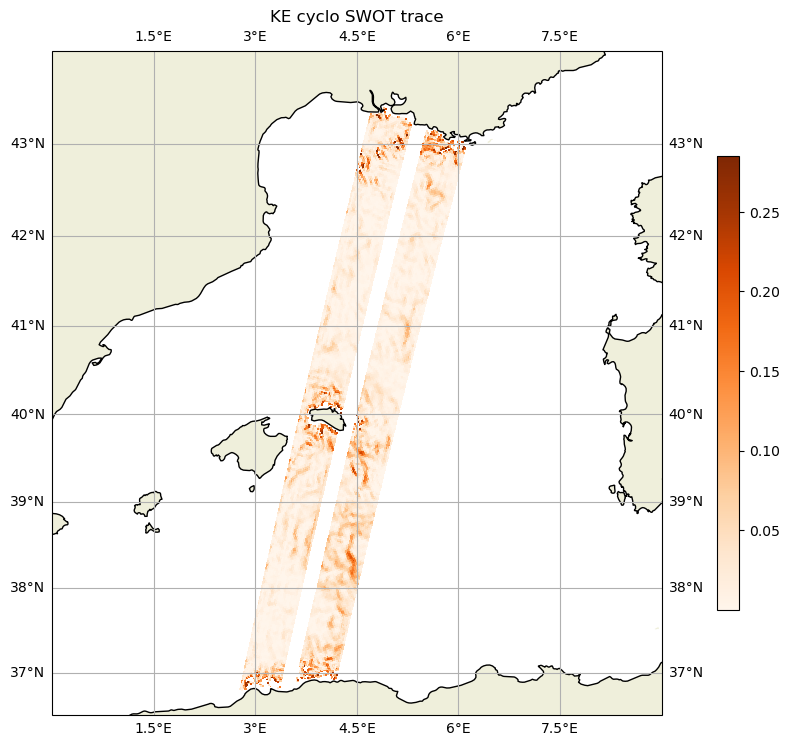

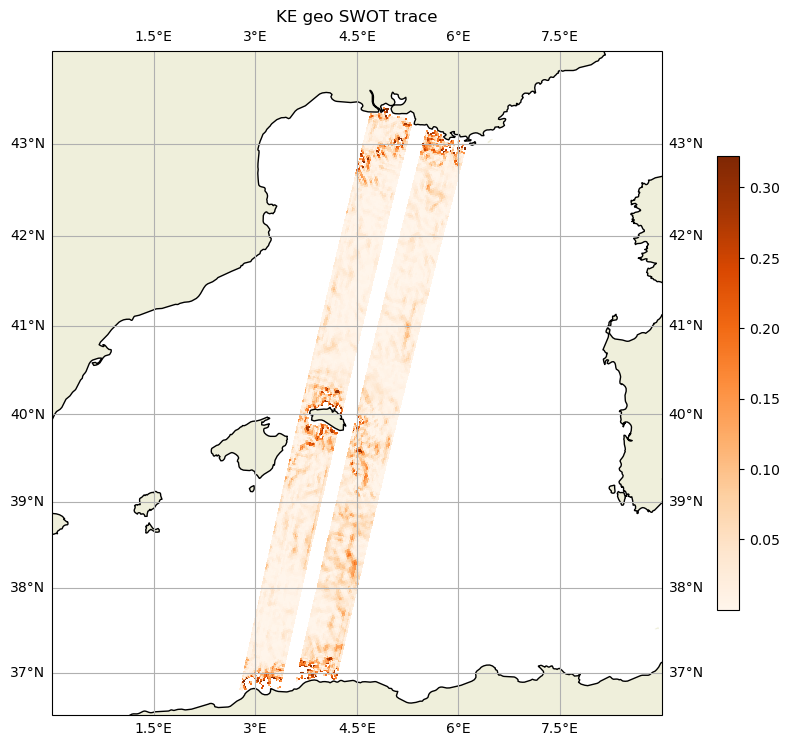

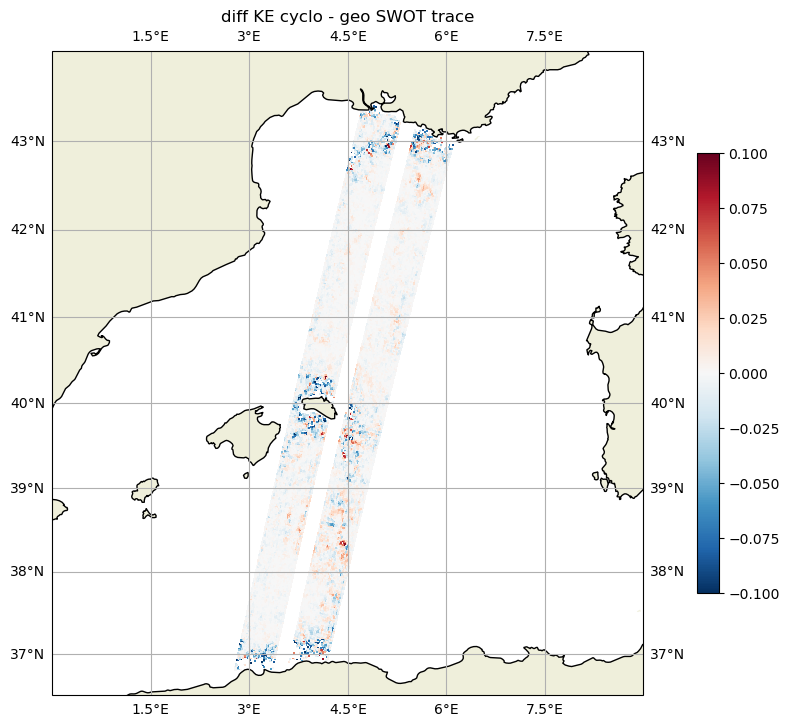

In [15]:
#plot data
plot2d(lon, lat, KE_var, bbox, center_bar=False, title='KE cyclo SWOT trace')
plot2d(lon, lat, KE_geo, bbox, center_bar=False, title='KE geo SWOT trace')
plot2d(lon, lat, diff, bbox, cmap='RdBu_r', center_bar=True, vmax= 0.1, title='diff KE cyclo - geo SWOT trace')

### Vorticity

In [11]:
ds=ds_swot
#ds = ds.interp(time='2023-05-15')
ds = ds.sel(time=slice(start_time, end_time)).mean(dim='time')

u_geos = jnp.copy(ds.u_geos.values)
v_geos = jnp.copy(ds.v_geos.values)
u_var = jnp.copy(ds.u_var.values)
v_var = jnp.copy(ds.v_var.values)

lon_t = jnp.copy(ds.longitude.values)
lat_t = jnp.copy(ds.latitude.values)

'''
lat_u = lat
lat_v = lat
lon_u = lon
lon_v = lon
'''

mask = jnp.isnan(u_geos)

lat_u, lon_u, lat_v, lon_v = jpw.tools.geometry.compute_uv_grids(lat_t, lon_t)

norm_vorticity_geos_raw = jpw.tools.kinematics.normalized_relative_vorticity(u_geos, v_geos, lat_u, lon_u, lat_v, lon_v, mask, interpolate=True)
norm_vorticity_var_raw  = jpw.tools.kinematics.normalized_relative_vorticity(u_var, v_var, lat_u, lon_u, lat_v, lon_v, mask, interpolate=True)

In [12]:
norm_vorticity_geos, _ = replace_outliers_with_nan_zscore(np.array(norm_vorticity_geos_raw), 3)
norm_vorticity_var, _  = replace_outliers_with_nan_zscore(np.array(norm_vorticity_var_raw), 3)

diff = (norm_vorticity_var - norm_vorticity_geos)
diff, _  = replace_outliers_with_nan_zscore(np.array(diff), 3)

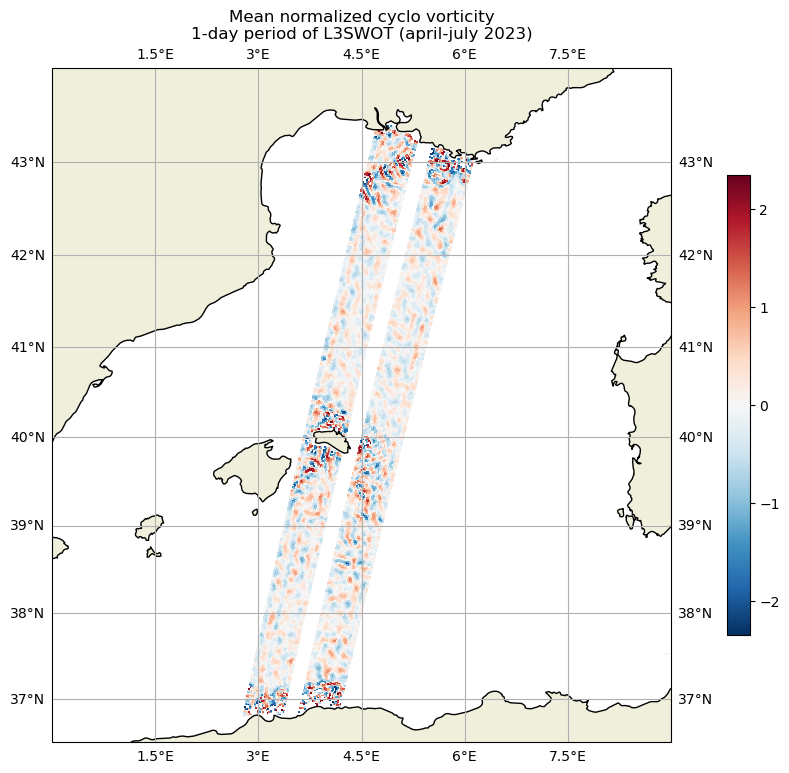

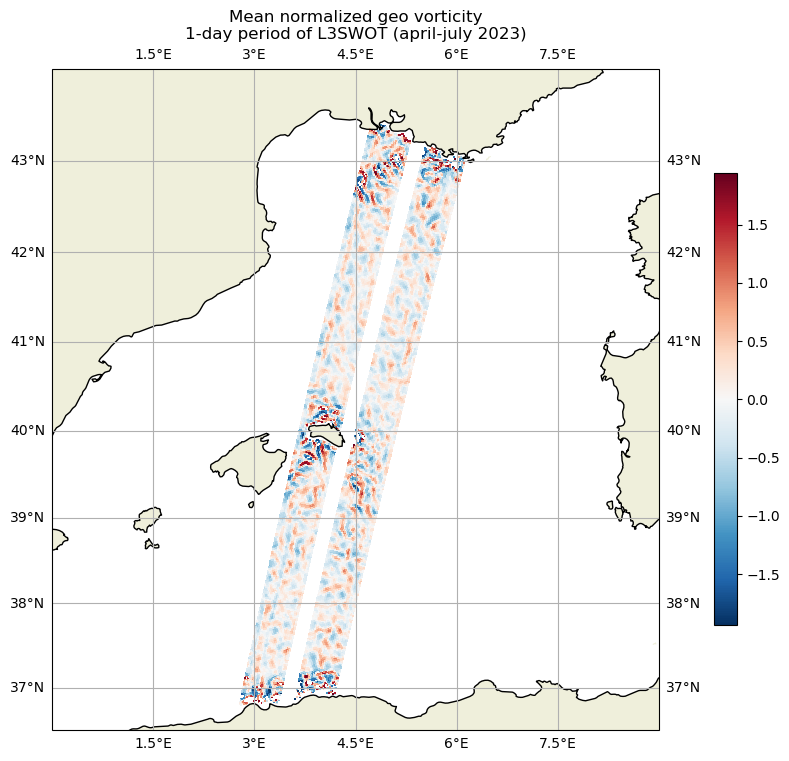

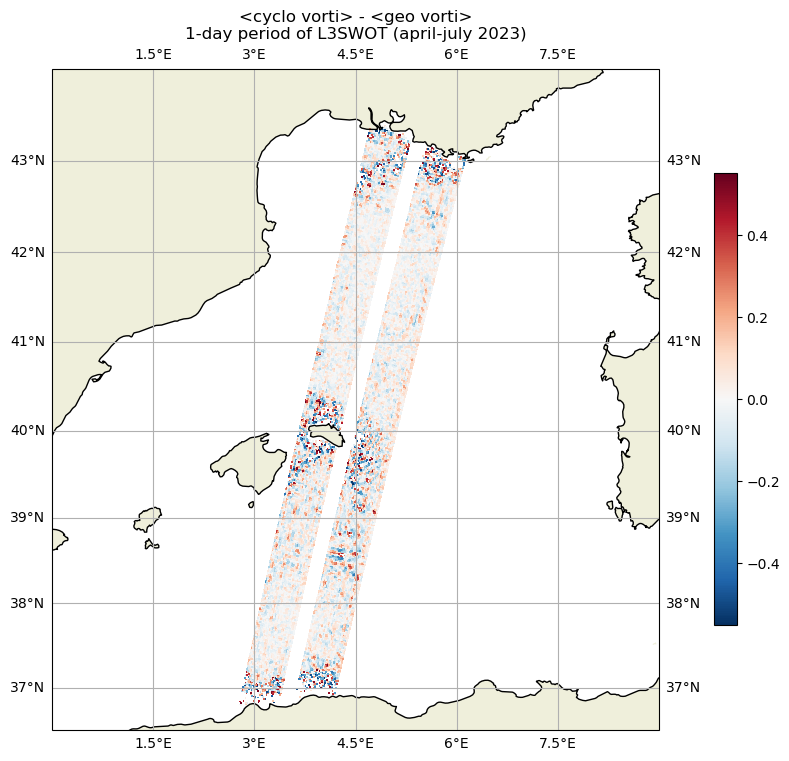

In [13]:
#plot data

plot2d(lon_t, lat_t, norm_vorticity_geos, bbox=bbox_trace, cmap='RdBu_r', center_bar=True, title='Mean normalized cyclo vorticity\n1-day period of L3SWOT (april-july 2023)')
plt.savefig(os.path.join(path_save_plot, 'Mean normalized cyclo vorticity 1-day period of L3SWOT (april-july 2023)'), bbox_inches='tight', dpi = 300)

plot2d(lon_t, lat_t, norm_vorticity_var, bbox=bbox_trace, cmap='RdBu_r', center_bar=True, title='Mean normalized geo vorticity\n1-day period of L3SWOT (april-july 2023)')
plt.savefig(os.path.join(path_save_plot, 'Mean normalized geo vorticity 1-day period of L3SWOT (april-july 2023)'), bbox_inches='tight', dpi = 300)

plot2d(lon_t, lat_t, diff, bbox=bbox_trace, cmap='RdBu_r', center_bar=True, title='<cyclo vorti> - <geo vorti>\n1-day period of L3SWOT (april-july 2023)')
plt.savefig(os.path.join(path_save_plot, '<cyclo vorti> - <geo vorti> 1-day period of L3SWOT (april-july 2023)'), bbox_inches='tight', dpi = 300)


### Animation vorticity

In [26]:

plt.ioff()
for i, time in enumerate(ds_swot.time.values):
    ds = ds_swot.isel(time=i)
    strtime = str(time)[:10] + '_'+ str(time)[11:13] +'h'

    u_geos = jnp.copy(ds.u_geos.values)
    v_geos = jnp.copy(ds.v_geos.values)
    u_var = jnp.copy(ds.u_var.values)
    v_var = jnp.copy(ds.v_var.values)

    lon_t = jnp.copy(ds.longitude.values)
    lat_t = jnp.copy(ds.latitude.values)

    '''
    lat_u = lat
    lat_v = lat
    lon_u = lon
    lon_v = lon
    '''

    mask = jnp.isnan(u_geos)

    lat_u, lon_u, lat_v, lon_v = jpw.tools.geometry.compute_uv_grids(lat_t, lon_t)

    #norm_vorticity_geos_raw = jpw.tools.kinematics.normalized_relative_vorticity(u_geos, v_geos, lat_u, lon_u, lat_v, lon_v, mask, interpolate=True)
    norm_vorticity_var_raw  = jpw.tools.kinematics.normalized_relative_vorticity(u_var, v_var, lat_u, lon_u, lat_v, lon_v, mask, interpolate=True)
    
    
    #plot data
    plot2d(lon, lat, norm_vorticity_var_raw, bbox=BBOX_SWATH, cmap='RdBu_r', center_bar=True, vmax=3, title='Cyclo normalized vorticity\n{}  L3SWOT'.format(strtime))
    plt.savefig(os.path.join('/home/bouxdecl/Documents/animation_sandbox3', '{}_{:03d}'.format('Cyclo_vorticity_L3SWOT', i)), bbox_inches='tight', dpi = 300)

    #plot2d(lon, lat, KE_geo, bbox=BBOX_SWATH, center_bar=False, vmax=0.4, title='Geo KE\n{}  L3SWOT'.format(strtime))
    #plt.savefig(os.path.join('/home/bouxdecl/Documents/animation_sandbox2', '{}_{:03d}'.format('Geo_KE_L3SWOT', i)), bbox_inches='tight', dpi = 300)

    #plot2d(lon, lat, diff, bbox, cmap='RdBu_r', center_bar=True, vmax= 1, title='<cyclo KE> - <geo KE>\n{}  L3SWOT'.format(strtime))
    #plt.savefig(os.path.join('/home/bouxdecl/Documents/animation_sandbox3', '{}_{:03d}'.format('Diff_cyclogeo_KE_L3SWOT', i)), bbox_inches='tight', dpi = 300)

/tmp/ipykernel_7204/3304770708.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(tight_layout=True, figsize=(8, 8))
